# Setup

## Installation

In [1]:
!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 26kB/s 
ERROR: torchvision 0.9.1+cu101 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.6.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.1+cu101
    Uninstalling torch-1.8.1+cu101:
      Successfully uninstalled torch-1.8.1+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 5.9MB 35.6MB/s 
  Found existing installation: torchvision 0.9.1+cu101
    Uninstalling torchvision-0.9.1+cu101:
      Successfully uninstalled torchvision-0.9.1+cu101
     |████████████████████████████████| 20.6MB 147kB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 645kB 36.0MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210604-cp37-no

In [2]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2021-06-08 08:05:25--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1472 (1.4K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.44K  --.-KB/s    in 0s      

2021-06-08 08:05:25 (37.4 MB/s) - ‘plot_image_grid.py’ saved [1472/1472]



## Mount the Drive

In [3]:
### mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Importing libraries and setup CUDA

In [4]:
import os
import sys
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

sys.path.append(os.path.abspath(''))



### CUDA Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

## Load the obj model
* edit the obj_filename and then procede.
* You can alo edit the num_views also to see the different result it creates.

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:495: UserWarning: Mtl file does not exist: model_normalized.mtl
  warnings.warn(f"Mtl file does not exist: {f_mtl}")


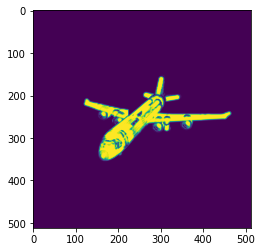

In [12]:
import cv2
obj_filename = 'target.obj'


num_views = 20

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])


R, T = look_at_view_transform(dist=0.8, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize 
# results
camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...]) 

# Rasterization settings for silhouette rendering  
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=512, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

obj_filename_2 = 'out_20.obj'

start_mesh = load_objs_as_meshes([obj_filename_2], device=device)
# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)
inds=3
imgs=renderer_silhouette(mesh)
plt.imshow(imgs[0, ..., inds].cpu().detach().numpy())


In [13]:
meshes = mesh.extend(num_views)

silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

In [8]:
# Visualize silhouette images
# image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
# plt.show()

## Training Loop

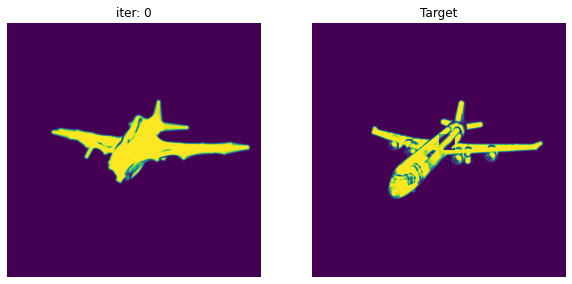

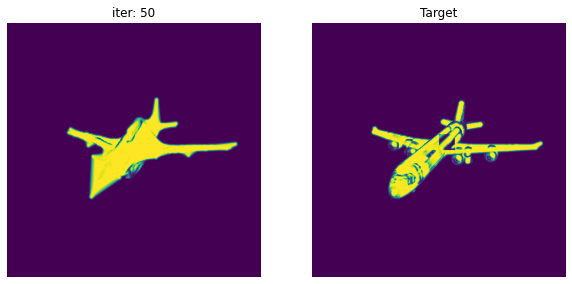

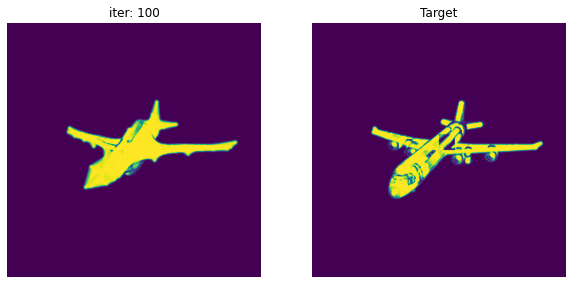

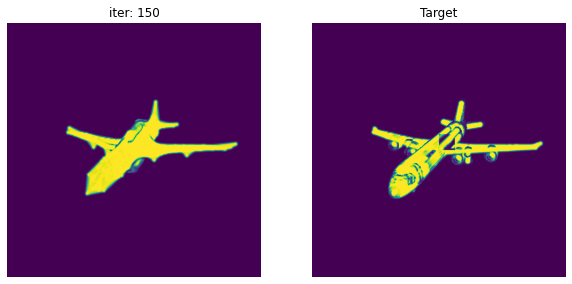

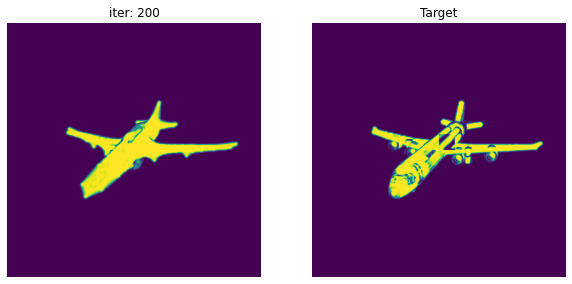

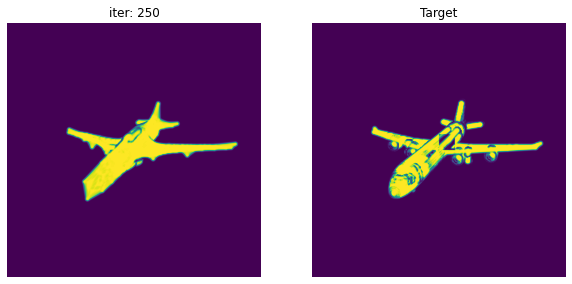

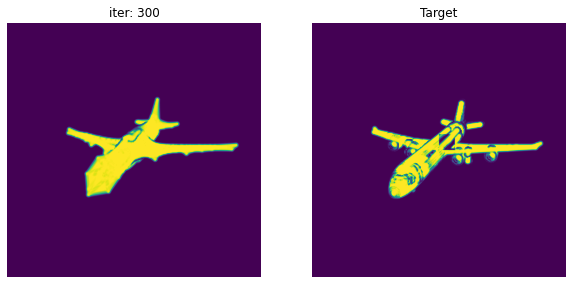

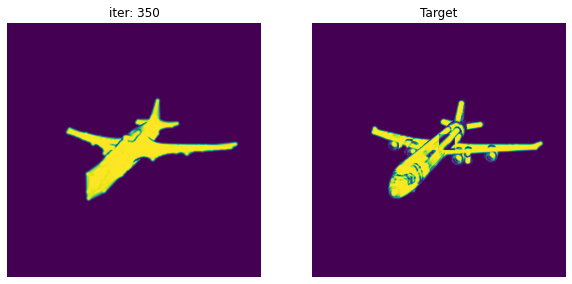

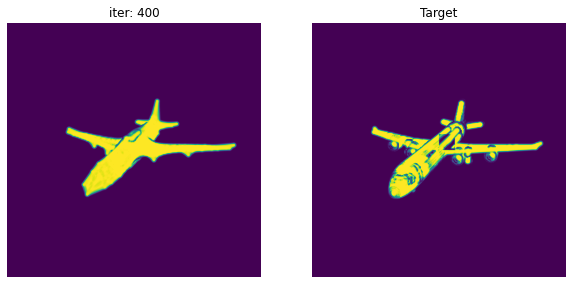

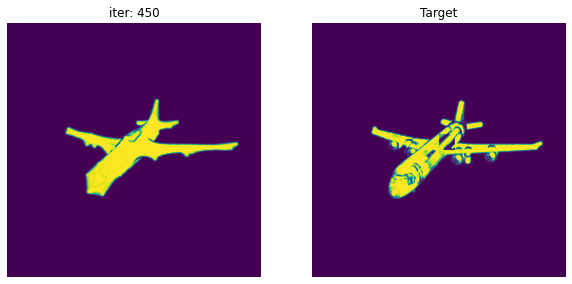

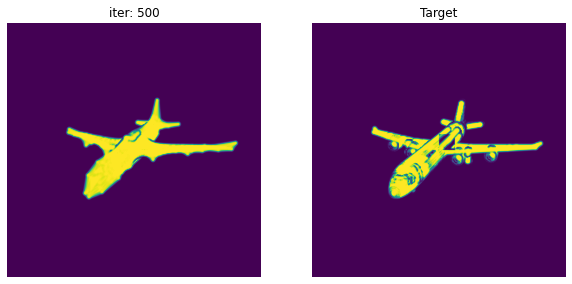

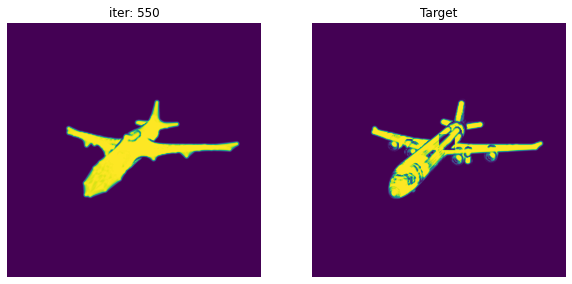

In [14]:
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

camera = OpenGLPerspectiveCameras(device=device, R=R[None, 1, ...], 
                                  T=T[None, 1, ...])

target_cameras = [OpenGLPerspectiveCameras(device=device, R=R[None, i, ...], 
                                           T=T[None, i, ...]) for i in range(num_views)]


# src_mesh = ico_sphere(4, device)
src_mesh=start_mesh
# new_src_mesh = src_mesh.offset_verts(deform_verts)

# verts = mesh.verts_packed()
# N = verts.shape[0]
# center = verts.mean(0)
# scale = max((verts - center).abs().max(0)[0])
# mesh.offset_verts_(-center.expand(N, 3))
# mesh.scale_verts_((1.0 / float(scale)));



# Create the renderer
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    image_size=512, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=50, 
    perspective_correct = False
)

# Silhouette renderer 
renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=raster_settings_soft
    ),
    shader=SoftSilhouetteShader()
)

def visualize_prediction(mesh , target_image , 
                         renderer = renderer_silhouette , 
                         silhouette = True ,
                         title1 = "" , 
                         title2 = "Target" ,
                         index = 0) :
    inds = 3 if silhouette else range(3)
    predicted_images = renderer(mesh)

    plt.figure(figsize = (10,8))
    
    plt.subplot(1, 2, 1)
    plt.title(title1)
    pred_image=predicted_images[0, ..., inds].cpu().detach().numpy()
    pred_image[pred_image>0]=167
    pred_image[pred_image==0]=255
    if index == 0 :
        index='00'
    elif index==50 :
        index='01'
    cv2.imwrite(f'noutput/{index}.jpg' , pred_image)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())
    plt.grid("off")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title(title2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.grid("off")
    plt.axis("off")

def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")



# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 2
# Number of optimization steps
Niter = 600
# Plot period for the losses
plot_period = 50

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal 
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.01, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)
    
    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)
    
    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

### Training Loop
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()
    
    # Deform the mesh
    
    new_src_mesh = src_mesh.offset_verts(deform_verts)
    
    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)
    
    # Compute the average silhouette loss over two random views, as the average 
    # squared L2 distance between the predicted silhouette and the target 
    # silhouette from our dataset
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_silhouette(new_src_mesh, cameras=target_cameras[j], lights=lights)
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration
    
    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l)
    
    # Print the losses
    loop.set_description("total_loss = %.3f" % sum_loss)
    
    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, title1="iter: %d" % i, silhouette=True,
                             target_image=target_silhouette[1],index=i)
        
    # Optimization step
    sum_loss.backward()
    optimizer.step()

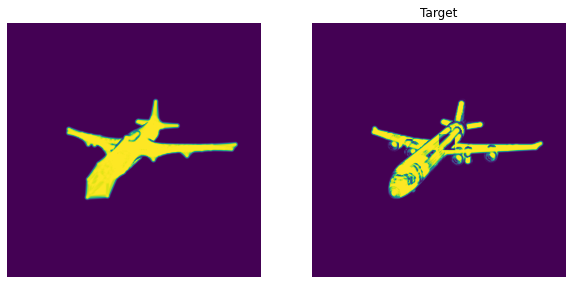

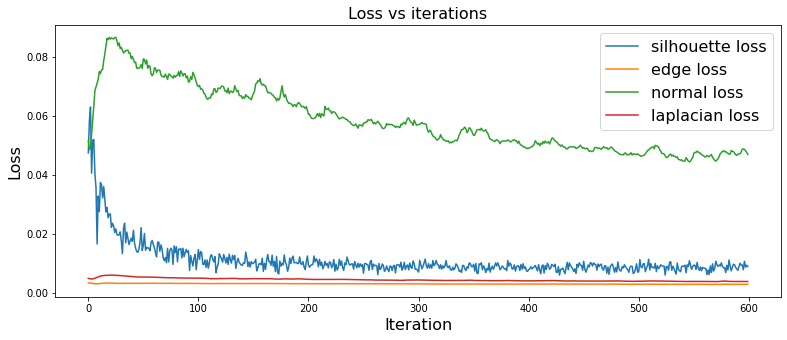

In [15]:
visualize_prediction(new_src_mesh, silhouette=True, 
                     target_image=target_silhouette[1])
plot_losses(losses)

In [16]:
mesh = new_src_mesh
verts = mesh.verts_packed()
N = verts.shape[0]
center = verts.mean(0)
scale = max((verts - center).abs().max(0)[0])
mesh.offset_verts_(-center.expand(N, 3))
mesh.scale_verts_((1.0 / float(scale)));


final_verts, final_faces = mesh.get_mesh_verts_faces(0)
final_verts = final_verts * scale + center
# final_obj = os.path.join('./', 'out_{}.obj'.format(num_views))
final_obj = os.path.join('./', 'final_output.obj'.format(num_views))

save_obj(final_obj, final_verts, final_faces)